Implementing an Autoencoder in PyTorch
===

This is adapted from the workbook provided alongside the article "Implementing an Autoencoder in Pytorch" which can be found [here](https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1). The primary differences are that the network is much larger (as the code is designed to work with much larger images) and the model is split into two parts to allow for differential encode/decode metrics such as Mahalanobis Distance.

This version of the model is designed with a convolutional model.


## Setup

We begin by importing our dependencies.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import math
import numpy
import collections
import gc

from model import OldSplitAutoencoder,SplitAutoencoder,ExtensibleEncoder,ExtensibleDecoder
from CustomDataSet import CustomDataSet


from torch.utils.data import Dataset
from natsort import natsorted
from PIL import Image
import os

import GPUtil

Set our seed and other configurations for reproducibility.

In [2]:
seed = 42
#seed = 2662

torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

if torch.cuda.is_available():
    platform = "cuda"
else:
    platform = "cpu"
print(platform)

print("memory at beginning of run")
GPUtil.showUtilization()

cuda
memory at beginning of run
| ID | GPU | MEM |
------------------
|  0 |  0% | 56% |


We set the batch size, the number of training epochs, and the learning rate. Batch size has to be reasonably low as we can't fit a huge number of these images into VRAM on my laptop.

Image size can be set here as I'm automatically resizing the images in my extraction code.

In [3]:
width = 256
height = 256

image_size = width * height

epochs = 150
learning_rate = 1e-5

batch_size = 4

#meta-parameters
l2_decays = [0.0]
dropout_rates = [0.0]
code_sides = [10]
code_size=100
convolution_filters = [32]

#image_count = 200
image_count = -1

validation_split = 0.95

early_stopping_bracket = 20
early_stopping_forgiveness = 6

## Dataset

Using a custom dataset class to load the images:

In [4]:
from torchvision.transforms import ToTensor,Normalize
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.0,65535.0)
    ])

root_dir = "../../Data/OPTIMAM_NEW/png_images/lesions/"
train_dataset = CustomDataSet(root_dir, transform)
if (image_count == -1):
    train_dataset_subset = train_dataset
else:
    train_dataset_subset = torch.utils.data.Subset(train_dataset, numpy.random.choice(len(train_dataset), image_count, replace=False))

dataset_size = len(train_dataset_subset)

# Randomly splitting indices:
val_len = int(np.floor((1.0 - validation_split) * dataset_size))
print(val_len)
split = dataset_size - val_len
print(split)
      
t_subset = torch.utils.data.Subset(train_dataset_subset, range(0,split))
v_subset = torch.utils.data.Subset(train_dataset_subset, range(split+1,dataset_size)) 
#np.random.shuffle(indices)
#train_indices, valid_indices = indices[split:], indices[:split]
#train_sampler = SubsetRandomSampler(train_indices)
#valid_sampler = SubsetRandomSampler(valid_indices)

train_loader = torch.utils.data.DataLoader(
    t_subset, batch_size=batch_size
)


valid_loader = torch.utils.data.DataLoader(
    v_subset, batch_size=batch_size
)

data_loaders = {"train": train_loader, "val": valid_loader}
data_lengths = {"train": len(t_subset), "val": len(t_subset)}

438
8337


In [5]:
#  use gpu if available
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
run_device = torch.device(platform)
store_device = torch.device("cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu

models = []
optimizers = []

print("memory before model construction")
GPUtil.showUtilization()


for i in range(len(code_sides)):
    models.append([])
    optimizers.append([])
    code_size = code_sides[i] * code_sides[i]
    for j in range(len(convolution_filters)):
        filters =  convolution_filters[j]
        models[i].append([])
        optimizers[i].append([])
        for k in range(len(dropout_rates)):
            dropout_rate = dropout_rates[k]
            models[i][j].append([])
            optimizers[i][j].append([])
            for l in range(len(l2_decays)):
                l2_decay = l2_decays[l]
                #new_model = SplitAutoencoder(input_shape=(height,width),code_size=code_size,convolutions=filters,dropout_chance=dropout_rate).to(store_device)
                new_model = SplitAutoencoder(input_shape=(height,width),code_size=code_size).to(store_device)
                new_optimizer = optim.Adam(new_model.parameters(), weight_decay=l2_decay, lr=learning_rate)
                models[i][j][k].append(new_model)
                optimizers[i][j][k].append(new_optimizer)

print("memory after model construction")
GPUtil.showUtilization()
# mean-squared error loss
#criterion = nn.MSELoss(reduction='sum')
#criterion = nn.MSELoss(reduction='mean')
criterion = nn.MSELoss()
#criterion = nn.MSELoss(reduction='none')

memory before model construction
| ID | GPU | MEM |
------------------
|  0 |  0% | 56% |
memory after model construction
| ID | GPU | MEM |
------------------
|  0 |  0% | 56% |


We use a grid parameter search method to train our autoencoder for our specified number of epochs for each combination of code sizes and convolutional filters

In [6]:
best_model_dicts = []
# populate with fake best models
for i in range(len(code_sides)):
    best_model_dicts.append([])
    for j in range(len(convolution_filters)):
        best_model_dicts[i].append([])
        for k in range(len(dropout_rates)):
            best_model_dicts[i][j].append([])
            for l in range(len(l2_decays)):
                best_model_dicts[i][j][k].append((65535.0,None))
print(best_model_dicts)

[[[[(65535.0, None)]]]]


In [7]:
train_losses = []
val_losses = []

batch_features_n = torch.empty(batch_size, 1, width, height, dtype=torch.float32)
for i in range(len(code_sides)):
    train_losses.append([])
    val_losses.append([])

    for j in range(len(convolution_filters)):
        train_losses[i].append([])
        val_losses[i].append([])

        for k in range(len(dropout_rates)):
            train_losses[i][j].append([])
            val_losses[i][j].append([])
            for l in range(len(l2_decays)):
                early_stopping_hits = 0
                train_losses[i][j][k].append([])
                val_losses[i][j][k].append([])
                print("==================")
                print("Running for code size:" + str(code_sides[i] * code_sides[i]) + ", filter size:"+str(convolution_filters[j]) + " with L2/dropout:" + str(l2_decays[l]) + "/" + str(dropout_rates[k]))
                try:
                    model_n = models[i][j][k][l].to(run_device)
                    if torch.cuda.device_count() > 1:
                        model_n = nn.DataParallel(model_n)
                    optimo = optimizers[i][j][k][l]
                    for epoch in range(epochs):
                        losses = {'train':0.0, 'val':0.0}

                        for phase in ['train', 'val']:
                            if phase == 'train':
                                model_n.train()  # Set model to training mode
                            else:
                                model_n.eval()  # Set model to evaluate mode

                            for batch_features in data_loaders[phase]:
                                # load it to the active device
                                batch_features_n = batch_features.to(run_device)

                                # reset the gradients back to zero
                                # PyTorch accumulates gradients on subsequent backward passes
                                optimo.zero_grad()

                                # compute reconstructions
                                codes = model_n.encoder(batch_features_n)
                                outputs = model_n.decoder(codes)

                                # compute training reconstruction loss
                                local_losses = criterion(outputs,batch_features_n)
                                
                                #penalise any all-black outputs
                                #for ind in range(len(local_losses)):
                                #    if(torch.sum(outputs[ind]) == 0.0):
                                #        local_losses[ind] = local_losses[ind] * 2
                                
                                #calculate mean batch loss (including all-black penalty)
                                local_loss = torch.mean(local_losses)

                                if phase == 'train':
                                    # compute accumulated gradients
                                    local_losses.backward()

                                    # perform parameter update based on current gradients
                                    optimo.step()

                                # add the mini-batch training loss to epoch loss
                                losses[phase] += local_loss.item()

                                del local_loss
                                del codes
                                del outputs


                        # compute the epoch training loss

                        losses['train'] = losses['train'] / len(data_loaders['train'])
                        losses['val'] = losses['val'] / len(data_loaders['val'])

                        #check if best model
                        if(losses['val'] < best_model_dicts[i][j][k][l][0]):
                            print("new best!")
                            model_dict = {}
                            for key, v in model_n.state_dict().items():
                                  model_dict[key] = v.cpu()
                            best_model_dicts[i][j][k][l] = (losses['val'],model_dict)

                        train_losses[i][j][k][l].append(losses['train'])
                        val_losses[i][j][k][l].append(losses['val'])

                        # display the epoch training loss
                        print("epoch : {}/{}, train loss = {:.8f}, validation loss = {:.8f}".format(epoch + 1, epochs, losses['train'],losses['val']))

                        #early stopping
                        if(epoch>early_stopping_bracket+1):
                            if(val_losses[i][j][k][l][epoch-early_stopping_bracket] <= losses['val']):
                                # early stopping situation found. see if we need to stop yet
                                early_stopping_hits = early_stopping_hits + 1
                                if(early_stopping_hits > early_stopping_forgiveness):
                                    print("Early stopping!")
                                    break
                            else:
                                if(early_stopping_hits > 0):
                                    early_stopping_hits = early_stopping_hits - 1

                    del model_n
                    del optimo
                    torch.cuda.empty_cache()
                except RuntimeError as e:
                    print("Can't complete this model due to:" + str(e))
                    model_n = None
                    optimo = None

                print("Memory at model end")
                GPUtil.showUtilization()

print('\a')

Running for code size:100, filter size:32 with L2/dropout:0.0/0.0


C:\Users\chali\Miniconda3\envs\pytorch\lib\site-packages\torchvision\transforms\functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
C:\Users\chali\Miniconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


new best!
epoch : 1/150, train loss = 0.01861810, validation loss = 0.00993036
new best!
epoch : 2/150, train loss = 0.00912979, validation loss = 0.00863987
new best!
epoch : 3/150, train loss = 0.00797442, validation loss = 0.00795934
new best!
epoch : 4/150, train loss = 0.00730201, validation loss = 0.00750247
new best!
epoch : 5/150, train loss = 0.00687055, validation loss = 0.00720060
new best!
epoch : 6/150, train loss = 0.00657364, validation loss = 0.00701215
new best!
epoch : 7/150, train loss = 0.00633686, validation loss = 0.00684871
new best!
epoch : 8/150, train loss = 0.00615663, validation loss = 0.00673385
new best!
epoch : 9/150, train loss = 0.00603542, validation loss = 0.00664632
new best!
epoch : 10/150, train loss = 0.00596500, validation loss = 0.00658371
new best!
epoch : 11/150, train loss = 0.00585807, validation loss = 0.00651322
new best!
epoch : 12/150, train loss = 0.00577255, validation loss = 0.00646217
new best!
epoch : 13/150, train loss = 0.00568199

Restore the best trained model and save.

In [8]:
print("memory before model restoration")
GPUtil.showUtilization()
#print(best_model_dicts)
for i in range(len(code_sides)):
    for j in range(len(convolution_filters)):
        for k in range(len(dropout_rates)):
            for l in range(len(l2_decays)):
                if(best_model_dicts[i][j][k][l][1]!=None):
                    print("Restoring best model for "+ str(i) + "/" + str(j) + "/" + str(k) + "/" + str(l));
                    models[i][j][k][l].load_state_dict(best_model_dicts[i][j][k][l][1], )
                    PATH = "../../Data/OPTIMAM_NEW/model" + str(width) + "_" + str(code_sides[i]) + "_" + str(convolution_filters[j]) + "_" + str(dropout_rates[k]) + "_" + str(l2_decays[l]) + ".pt"
                    torch.save(models[i][j][k][l], PATH)

print("memory after model restoration")
GPUtil.showUtilization()

memory before model restoration
| ID | GPU | MEM |
------------------
|  0 | 56% | 78% |
Restoring best model for 0/0/0/0
memory after model restoration
| ID | GPU | MEM |
------------------
|  0 | 20% | 78% |


Let's extract some test examples to reconstruct using our trained autoencoder.

In [9]:
#test_dataset = CustomDataSet(root_dir, transform) # same transform as we used for the training, for compatibility
test_dataset = train_dataset_subset
if (image_count == -1):
    test_dataset_subset = test_dataset
else:
    test_dataset_subset = torch.utils.data.Subset(test_dataset, numpy.random.choice(len(test_dataset), image_count, replace=False))

test_loader = torch.utils.data.DataLoader(
    test_dataset_subset, batch_size=5, shuffle=True
)

test_example_sets = []
code_sets = []
reconstruction_sets = []

## Visualize Results

Let's try to reconstruct some test images using our trained autoencoder.

In [10]:
print("memory before testing")
GPUtil.showUtilization()
with torch.no_grad():
    for i in range(len(code_sides)):
        test_example_sets.append([])
        code_sets.append([])
        reconstruction_sets.append([])
        
        #test_example_sets.append([None] * len(convolution_filters))
        #code_sets.append([None] * len(convolution_filters))
        #reconstruction_sets.append([None] * len(convolution_filters))
        for j in range(len(convolution_filters)):
            test_example_sets[i].append([])
            code_sets[i].append([])
            reconstruction_sets[i].append([])
            for k in range(len(dropout_rates)):
                test_example_sets[i][j].append([None] * len(l2_decays))
                code_sets[i][j].append([None] * len(l2_decays))
                reconstruction_sets[i][j].append([None] * len(l2_decays))
                for l in range(len(l2_decays)):
                    if(best_model_dicts[i][j][k][l][1]!=None):
                        model_t = models[i][j][k][l].to(run_device)
                        for batch_features in test_loader:
                            test_examples = batch_features.to(run_device)
                            n_codes = model_t.encoder(test_examples)
                            reconstruction = model_t.decoder(n_codes)
                            break;
                        test_example_sets[i][j][k][l] = test_examples.to(store_device)
                        code_sets[i][j][k][l] = n_codes.to(store_device)
                        reconstruction_sets[i][j][k][l] = reconstruction.to(store_device)
                        del test_examples
                        del n_codes
                        del reconstruction
print("memory after testing")
GPUtil.showUtilization()

memory before testing
| ID | GPU | MEM |
------------------
|  0 |  0% | 78% |
memory after testing
| ID | GPU | MEM |
------------------
|  0 |  0% | 80% |


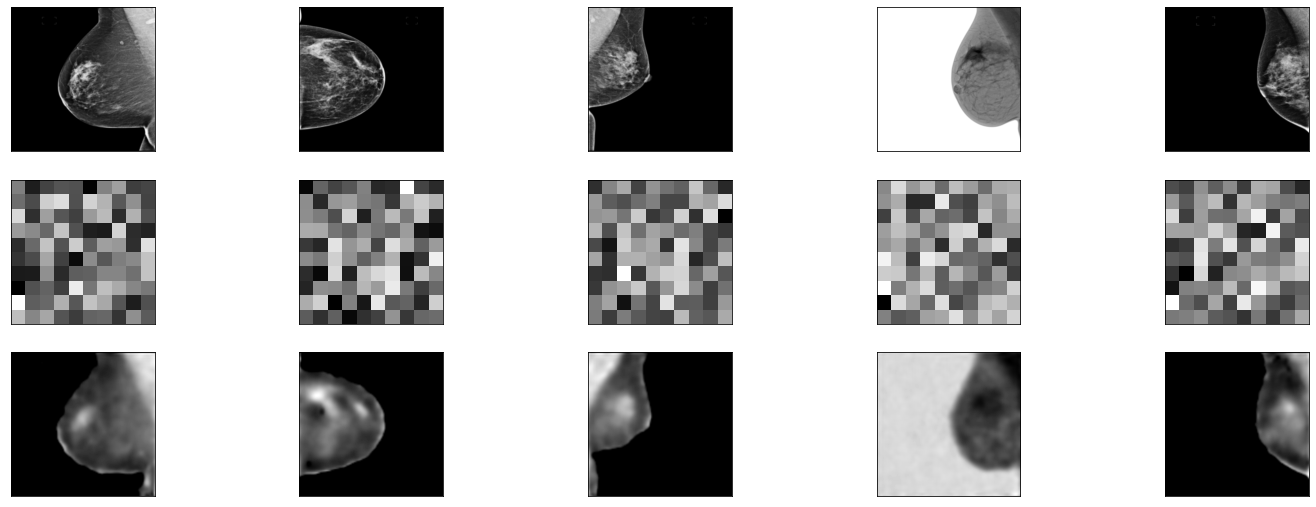

In [11]:
with torch.no_grad():
    for i in range(len(code_sides)):
        for j in range(len(convolution_filters)):
            for k in range(len(dropout_rates)):
                for l in range(len(l2_decays)):
                    if(best_model_dicts[i][j][k][l][1]!=None):
                        number = 5
                        plt.figure(figsize=(25, 9))
                        for index in range(number):
                            # display original
                            ax = plt.subplot(3, number, index + 1)
                            test_examples = test_example_sets[i][j][k][l]
                            copyback = test_examples[index].cpu()
                            #plt.imshow(copyback.numpy().reshape(height, width), vmin=0, vmax=65535)
                            plt.imshow(copyback.reshape(height, width))
                            plt.gray()
                            ax.get_xaxis().set_visible(False)
                            ax.get_yaxis().set_visible(False)

                            # display codes
                            ax = plt.subplot(3, number, index + 1 + number)
                            codes = code_sets[i][j][k][l]
                            code_copyback = codes[index].cpu()
                            plt.imshow(code_copyback.numpy().reshape(code_sides[i],code_sides[i]))
                            plt.gray()
                            ax.get_xaxis().set_visible(False)
                            ax.get_yaxis().set_visible(False)

                            # display reconstruction
                            ax = plt.subplot(3, number, index + 6 + number)
                            reconstruction = reconstruction_sets[i][j][k][l]
                            recon_copyback = reconstruction[index].cpu()
                            plt.imshow(recon_copyback.reshape(height, width))
                            plt.gray()
                            ax.get_xaxis().set_visible(False)
                            ax.get_yaxis().set_visible(False)

                        out_path = "output"+ str(width) + "_"  + str(code_sides[i]) + "_" + str(convolution_filters[j]) + "_" + str(dropout_rates[k]) + "_" + str(l2_decays[l]) +".png" 
                        plt.savefig(out_path)
                        #plt.show()

In [12]:
from quickemail import SendEmail
SendEmail("Run Completed","The new autoencoder run is complete", "wgr@aber.ac.uk")

email sent
